# Multi-Class Image Classification Deep Learning Model for Chinese MNIST Characters Using TensorFlow
### David Lowe
### September 10, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The Kaggle UT Zappos50K Shoe dataset is a multi-class classification situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: The Chinese MNIST dataset uses data collected by Dr. K Nazarpour and Dr. M Chen for a project at Newcastle University. One hundred Chinese nationals took part in data collection. Each participant wrote with a standard black ink pen all 15 numbers in a table with 15 designated regions drawn on a white A4 paper. Each participant repeated this process ten times, with each sheet scanned at the 300x300 pixels resolution. It resulted in a dataset of 15000 images, each representing one character from a set of 15 characters.

In this iteration, we will construct a few simple CNN models to predict the shoe category based on the available images.

ANALYSIS: The one-layer CNN model's performance achieved an average accuracy score of 92.79% on the test dataset after 15 epochs. The three-layer CNN model processed the same test dataset with an average accuracy measurement of 97.92%.

CONCLUSION: In this iteration, the simple CNN models appeared to be suitable for modeling this dataset. We should consider experimenting with TensorFlow for further modeling.

Dataset Used: Chinese MNIST Digit Recognizer

Dataset ML Model: Multi-class image classification with numerical attributes

Dataset Reference: https://www.kaggle.com/fedesoriano/chinese-mnist-digit-recognizer

One potential source of performance benchmarks: https://data.ncl.ac.uk/articles/Handwritten_Chinese_Numbers/10280831/1

A deep-learning image classification project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Images
3. Define and Train Models
4. Evaluate and Optimize Models
5. Finalize Model and Make Predictions

# Task 1 - Prepare Environment

In [1]:
# Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [2]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Mon Sep  6 17:00:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    32W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [4]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


## 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [6]:
# Load libraries and packages
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
from datetime import datetime
import zipfile
import h5py
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

## 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
VAL_SET_RATIO = 0.2
# TEST_SET_RATIO = 0.5

# Set the number of folds and iterations for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'categorical_crossentropy'
DEFAULT_METRICS = ['accuracy']
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0001)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomNormal(seed=RNG_SEED)
CLASSIFIER_ACTIVATION = 'softmax'
MAX_EPOCHS = 15
BATCH_SIZE = 32
# RAW_IMAGE_SIZE = (64, 64)
TARGET_IMAGE_SIZE = (64, 64)
INPUT_IMAGE_SHAPE = (TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1], 1)

NUM_CLASSES = 15
CLASS_LABELS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                100, 1000, 10000, 100000000]
CLASS_NAMES = ['Zero','One','Two','Three','Four','Five','Six','Seven',
               'Eight','Nine','Ten','Hundred','Thousand',
               'Ten Thousand','One Hundred Million']

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Define the directory locations and file names
# STAGING_DIR = ''
# TRAIN_DIR = ''
# VALID_DIR = ''
# TEST_DIR = ''
# TRAIN_DATASET = ''
# VALID_DATASET = ''
# TEST_DATASET = ''
# TRAIN_LABELS = ''
# VALID_LABELS = ''
# TEST_LABELS = ''
# OUTPUT_DIR = 'staging/'
# SAMPLE_SUBMISSION_CSV = 'sample_submission.csv'
# FINAL_SUBMISSION_CSV = 'submission.csv'

In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [10]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [11]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [12]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

## 2.a) Load Dataset

In [13]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-chinese-mnist-characters/chineseMNIST.csv'
df_dataset_import = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   pixel_0  pixel_1  pixel_2  pixel_3  ...  pixel_4094  pixel_4095  label  character
0        0        0        0        0  ...           0           0      9          九
1        0        0        0        0  ...           0           0      9          九
2        0        0        0        0  ...           0           0      9          九
3        0        0        0        0  ...           0           0      9          九
4        0        0        0        0  ...           0           0      9          九

[5 rows x 4098 columns]


In [14]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 4098 columns):
 #    Column      Dtype 
---   ------      ----- 
 0    pixel_0     int64 
 1    pixel_1     int64 
 2    pixel_2     int64 
 3    pixel_3     int64 
 4    pixel_4     int64 
 5    pixel_5     int64 
 6    pixel_6     int64 
 7    pixel_7     int64 
 8    pixel_8     int64 
 9    pixel_9     int64 
 10   pixel_10    int64 
 11   pixel_11    int64 
 12   pixel_12    int64 
 13   pixel_13    int64 
 14   pixel_14    int64 
 15   pixel_15    int64 
 16   pixel_16    int64 
 17   pixel_17    int64 
 18   pixel_18    int64 
 19   pixel_19    int64 
 20   pixel_20    int64 
 21   pixel_21    int64 
 22   pixel_22    int64 
 23   pixel_23    int64 
 24   pixel_24    int64 
 25   pixel_25    int64 
 26   pixel_26    int64 
 27   pixel_27    int64 
 28   pixel_28    int64 
 29   pixel_29    int64 
 30   pixel_30    int64 
 31   pixel_31    int64 
 32   pixel_32    int64 
 33   pixel_33

In [15]:
# Dropping unnecessary features
df_dataset_import.drop(columns=['character'], inplace=True)

# Standardize the class column to the name of target
df_dataset_import = df_dataset_import.rename(columns={'label':'target'})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

   pixel_0  pixel_1  pixel_2  ...  pixel_4094  pixel_4095  target
0        0        0        0  ...           0           0       9
1        0        0        0  ...           0           0       9
2        0        0        0  ...           0           0       9
3        0        0        0  ...           0           0       9
4        0        0        0  ...           0           0       9

[5 rows x 4097 columns]


In [16]:
print(df_dataset_import.describe())

       pixel_0  pixel_1  pixel_2  ...    pixel_4094    pixel_4095        target
count  15000.0  15000.0  15000.0  ...  15000.000000  15000.000000  1.500000e+04
mean       0.0      0.0      0.0  ...      0.001400      0.001333  6.667410e+06
std        0.0      0.0      0.0  ...      0.089807      0.095911  2.494502e+07
min        0.0      0.0      0.0  ...      0.000000      0.000000  0.000000e+00
25%        0.0      0.0      0.0  ...      0.000000      0.000000  3.000000e+00
50%        0.0      0.0      0.0  ...      0.000000      0.000000  7.000000e+00
75%        0.0      0.0      0.0  ...      0.000000      0.000000  1.000000e+02
max        0.0      0.0      0.0  ...      9.000000      8.000000  1.000000e+08

[8 rows x 4097 columns]


In [17]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

pixel_0       0
pixel_1       0
pixel_2       0
pixel_3       0
pixel_4       0
             ..
pixel_4092    0
pixel_4093    0
pixel_4094    0
pixel_4095    0
target        0
Length: 4097, dtype: int64
Total number of NaN in the dataframe:  0


## 2.b) Split Dataset and Preview Images

In [18]:
# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_feature_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_feature_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_feature_train.shape, df_target_train.shape))

df_dataset_import.shape: (15000, 4097) df_feature_train.shape: (15000, 4096) df_target_train.shape: (15000,)


In [19]:
# Normalize the data to reduce the effect of illumination's differences and help the CNN converges faster
array_feature_train = df_feature_train.to_numpy()
array_feature_train = array_feature_train / 255
print('array_feature_train.shape:', array_feature_train.shape)

array_feature_train.shape: (15000, 4096)


In [20]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
array_feature_train = array_feature_train.reshape(-1, 64, 64, 1)
print('array_feature_train.shape:', array_feature_train.shape)

array_feature_train.shape: (15000, 64, 64, 1)


<Figure size 1440x3240 with 0 Axes>

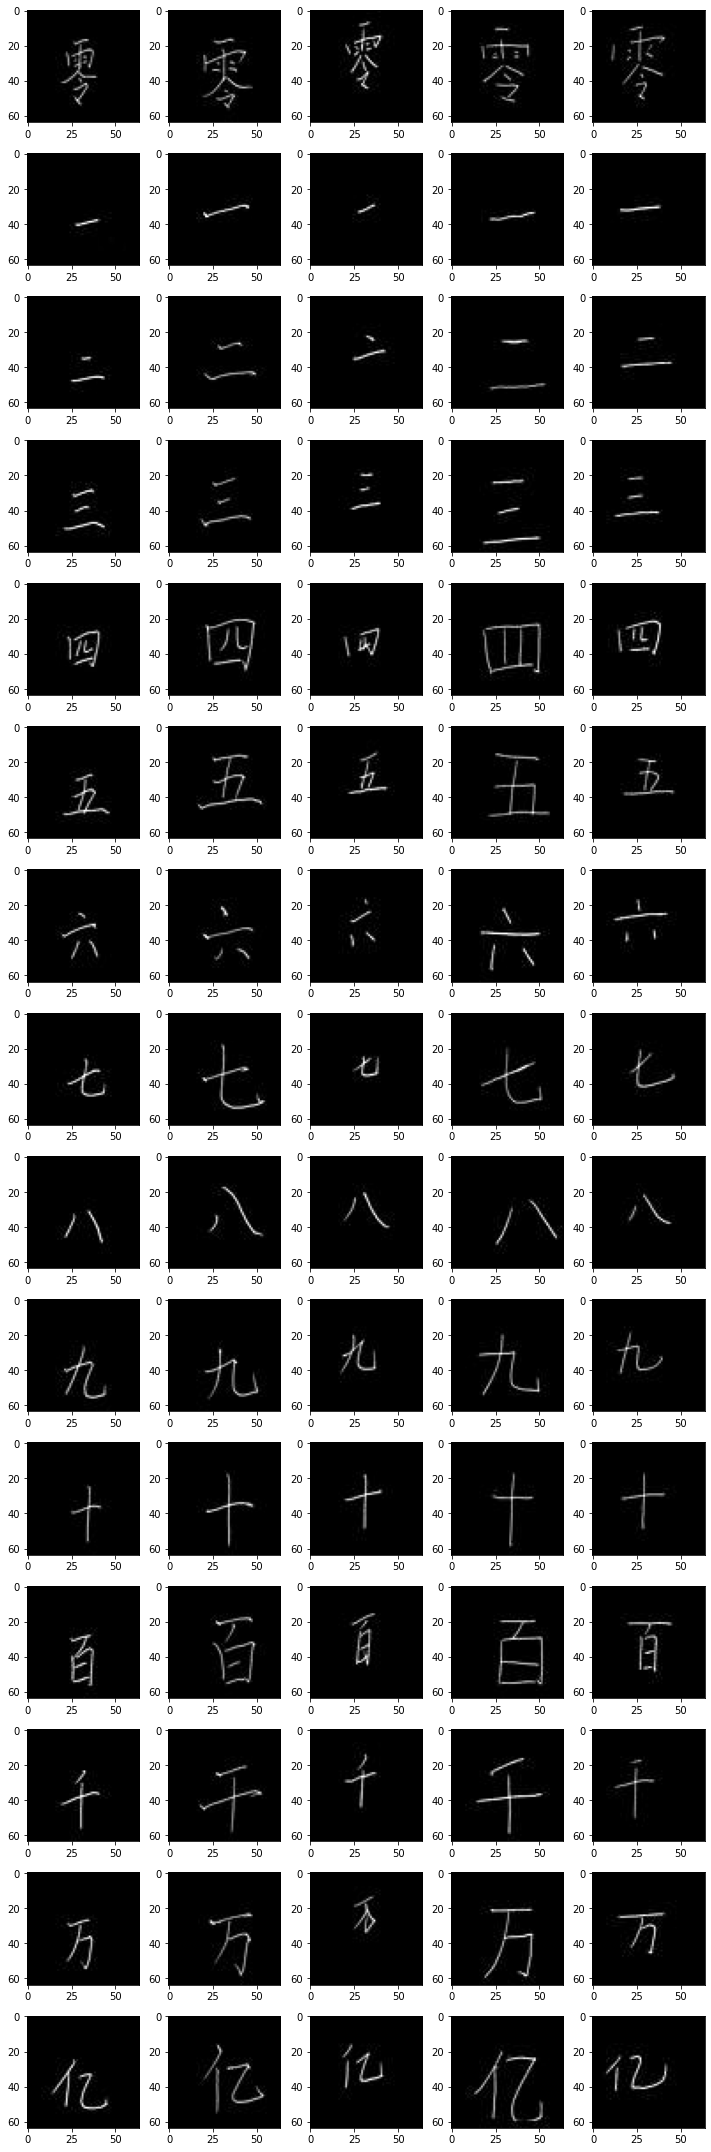

In [21]:
# Plot some training images from the dataset
nrows = NUM_CLASSES
ncols = 5
training_examples = []
example_labels = []

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 3)

for c_label in CLASS_LABELS:
    # print('Label:', c_label)
    training_image_list = df_target_train[df_target_train==c_label]
    # print('Length:', len(training_image_list))
    for j in range(ncols):
        # print('Appending:', training_image_list.index[j])
        training_examples.append(training_image_list.index[j*100])
        example_labels.append(c_label)
    # print(training_examples)
    # print(example_labels)

f, ax = plt.subplots(nrows, ncols)
f.set_size_inches(10, 30)
k = 0
for i in range(nrows):
    for j in range(ncols):
        ax[i, j].imshow(array_feature_train[training_examples[k]].reshape(64, 64), cmap="gray")
        k += 1
plt.tight_layout()
plt.show()

In [22]:
# Finalize the training dataset for the modeling activities
class_encoder = preprocessing.LabelBinarizer()
array_target_train = class_encoder.fit_transform(df_target_train)
# array_target_train = df_target_train.ravel()
print("array_feature_train.shape: {} array_target_train.shape: {}".format(array_feature_train.shape, array_target_train.shape))

array_feature_train.shape: (15000, 64, 64, 1) array_target_train.shape: (15000, 15)


In [23]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [24]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [25]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=INPUT_IMAGE_SHAPE, output_param=NUM_CLASSES,
                    conv1_filters=128, conv1_dropout=0, dense_nodes=512,
                    init_param=DEFAULT_INITIALIZER, classifier_activation=CLASSIFIER_ACTIVATION,
                    loss_param=DEFAULT_LOSS, opt_param=DEFAULT_OPTIMIZER, metric_param=DEFAULT_METRICS):
    nn_model = keras.Sequential([
        # This is the first convolution layer
        keras.layers.Conv2D(conv1_filters, (3,3), strides=1, padding='same', activation='relu', kernel_initializer=init_param, input_shape=input_param),
        keras.layers.MaxPooling2D((2,2), strides=2, padding='same'),
        # Flatten the results to feed into a DNN
        keras.layers.Flatten(),
        keras.layers.Dense(dense_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dense(output_param, activation=classifier_activation, kernel_initializer=init_param)
    ])
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metric_param)
    return nn_model

In [26]:
# Initialize the default model and get a baseline result
startTimeModule = datetime.now()
results = list()
iteration = 0
cv = RepeatedKFold(n_splits=N_FOLDS, n_repeats=N_ITERATIONS, random_state=RNG_SEED)
for train_ix, val_ix in cv.split(array_feature_train):
    feature_train, feature_validation = array_feature_train[train_ix], array_feature_train[val_ix]
    target_train, target_validation = array_target_train[train_ix], array_target_train[val_ix]
    reset_random()
    baseline_model = create_nn_model()
    baseline_model.fit(feature_train, target_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, verbose=0)
    model_metric = baseline_model.evaluate(feature_validation, target_validation, verbose=0)[1]
    iteration = iteration + 1
    print('Accuracy measurement from iteration %d >>> %.2f%%\n' % (iteration, model_metric*100))
    results.append(model_metric)
validation_score = np.mean(results)
validation_variance = np.std(results)
print('Average model accuracy from all iterations: %.2f%% (%.2f%%)' % (validation_score*100, validation_variance*100))
print('Total time for model fitting and cross validating:', (datetime.now() - startTimeModule))

Accuracy measurement from iteration 1 >>> 91.70%

Accuracy measurement from iteration 2 >>> 93.87%

Accuracy measurement from iteration 3 >>> 93.90%

Accuracy measurement from iteration 4 >>> 92.70%

Accuracy measurement from iteration 5 >>> 91.77%

Average model accuracy from all iterations: 92.79% (0.96%)
Total time for model fitting and cross validating: 0:11:17.315788


In [27]:
baseline_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 128)       1280      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               67109376  
_________________________________________________________________
dense_9 (Dense)              (None, 15)                7695      
Total params: 67,118,351
Trainable params: 67,118,351
Non-trainable params: 0
_________________________________________________________________


In [28]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Evaluate and Optimize Models

In [29]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [30]:
# Define the baseline model for benchmarking
def create_2n_model(input_param=INPUT_IMAGE_SHAPE, output_param=NUM_CLASSES,
                    conv1_filters=128, conv2_filters=128, conv3_filters=128,
                    conv1_dropout=0.25, conv2_dropout=0.25, conv3_dropout=0.25,
                    dense_nodes=1024, init_param=DEFAULT_INITIALIZER, classifier_activation=CLASSIFIER_ACTIVATION,
                    loss_param=DEFAULT_LOSS, opt_param=DEFAULT_OPTIMIZER, metric_param=DEFAULT_METRICS):
    nn_model = keras.Sequential([
        # This is the first convolution layer
        keras.layers.Conv2D(conv1_filters, (3,3), strides=1, padding='same', activation='relu', kernel_initializer=init_param, input_shape=input_param),
        keras.layers.Dropout(conv1_dropout),
        keras.layers.MaxPooling2D((2,2), strides=2, padding='same'),
        # This is the second convolution layer
        keras.layers.Conv2D(conv2_filters, (3,3), strides=1, padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(conv2_dropout),
        keras.layers.MaxPooling2D((2,2), strides=2, padding='same'),
        # This is the third convolution layer
        keras.layers.Conv2D(conv3_filters, (3,3), strides=1, padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(conv3_dropout),
        keras.layers.MaxPooling2D((2,2), strides=2, padding='same'),
        # Flatten the results to feed into a DNN
        keras.layers.Flatten(),
        keras.layers.Dense(dense_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dense(output_param, activation=classifier_activation, kernel_initializer=init_param)
    ])
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metric_param)
    return nn_model

In [31]:
# Initialize the default model and get a baseline result
startTimeModule = datetime.now()
results = list()
iteration = 0
cv = RepeatedKFold(n_splits=N_FOLDS, n_repeats=N_ITERATIONS, random_state=RNG_SEED)
for train_ix, val_ix in cv.split(array_feature_train):
    feature_train, feature_validation = array_feature_train[train_ix], array_feature_train[val_ix]
    target_train, target_validation = array_target_train[train_ix], array_target_train[val_ix]
    reset_random()
    enhanced_model = create_2n_model()
    enhanced_model.fit(feature_train, target_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, verbose=0)
    model_metric = enhanced_model.evaluate(feature_validation, target_validation, verbose=0)[1]
    iteration = iteration + 1
    print('Accuracy measurement from iteration %d >>> %.2f%%\n' % (iteration, model_metric*100))
    results.append(model_metric)
validation_score = np.mean(results)
validation_variance = np.std(results)
print('Average model accuracy from all iterations: %.2f%% (%.2f%%)' % (validation_score*100, validation_variance*100))
print('Total time for model fitting and cross validating:', (datetime.now() - startTimeModule))

Accuracy measurement from iteration 1 >>> 97.87%

Accuracy measurement from iteration 2 >>> 98.33%

Accuracy measurement from iteration 3 >>> 98.13%

Accuracy measurement from iteration 4 >>> 98.33%

Accuracy measurement from iteration 5 >>> 96.93%

Average model accuracy from all iterations: 97.92% (0.52%)
Total time for model fitting and cross validating: 0:11:29.134500


In [32]:
enhanced_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 64, 64, 128)       1280      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64, 64, 128)       0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
dropout_13 (Dropout)         (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 128)      

In [33]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [34]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [35]:
# Not applicable for this iteration of modeling

In [36]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [37]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:23:13.120922
